In [1]:
import os, sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm as LN
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
from HighLevelFeatures import HighLevelFeatures as HLF
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
torch.set_default_dtype(torch.float64)

In [3]:
ds2_folder = '/home/ck756/ML_source/CaloChallenge/'
ds3_folder = '/home/mb1403/Calochallenge/data'

ds2_layer_size = 9 * 16
ds3_layer_size = 18 * 50

In [4]:
data = h5py.File(ds2_folder+'dataset_2_1.hdf5', 'r')
Data_HLF = HLF('electron', filename='binning_dataset_2.xml')

In [5]:
E_inc = data['incident_energies'][:]
Showers = data['showers'][:]

In [6]:
first_layer = Showers[:, :ds2_layer_size]

In [7]:
def DrawSingleLayer(HLF_instance, data, layer_nr, title=None):
    """ draws the shower in layer_nr only """
    fig = plt.figure(figsize=(2, 2), dpi=200)
    num_splits = 400
    radii = np.array(HLF_instance.r_edges[layer_nr])
    if HLF_instance.particle != 'electron':
        radii[1:] = np.log(radii[1:])
    theta, rad = np.meshgrid(2.*np.pi*np.arange(num_splits+1)/ num_splits, radii)
    pts_per_angular_bin = int(num_splits / HLF_instance.num_alpha[layer_nr])

    data_reshaped = data.reshape(int(HLF_instance.num_alpha[layer_nr]), -1)
    data_repeated = np.repeat(data_reshaped, (pts_per_angular_bin), axis=0)
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.grid(False)
    pcm = ax.pcolormesh(theta, rad, data_repeated.T+1e-16, norm=LN(vmin=1e-2, vmax=data.max()))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if HLF_instance.particle == 'electron':
        ax.set_rmax(radii[-1])
    else:
        ax.set_rmax(np.log(radii[-1]))
    ax.set_title('Layer '+str(layer_nr))
    #wdth = str(len(self.r_edges)*100)+'%'
    axins = inset_axes(fig.get_axes()[-1], width='100%',
                        height="15%", loc='lower center', bbox_to_anchor=(0., -0.2, 1, 1),
                        bbox_transform=fig.get_axes()[-1].transAxes,
                        borderpad=0)
    cbar = plt.colorbar(pcm, cax=axins, fraction=0.2, orientation="horizontal")
    cbar.set_label(r'Energy (MeV)', y=0.83, fontsize=12)
    if title is not None:
        plt.gcf().suptitle(title)
    plt.show()

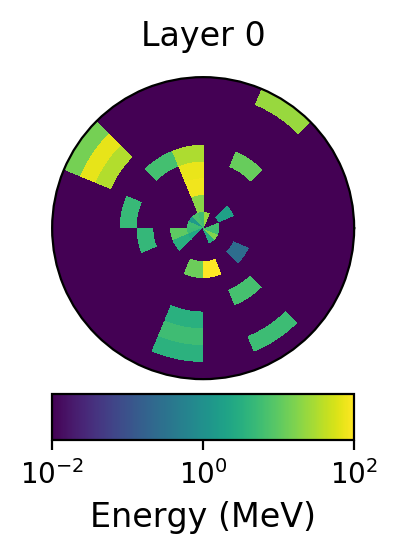

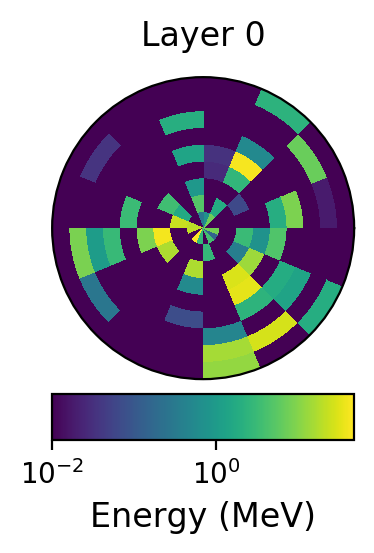

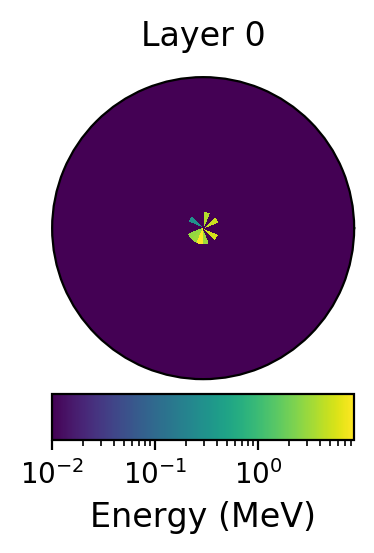

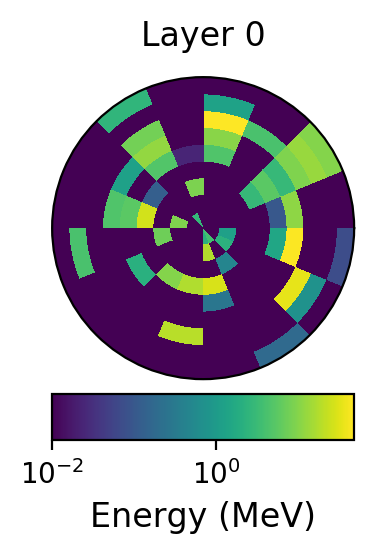

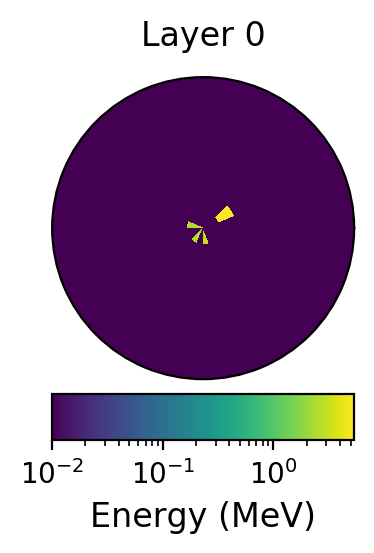

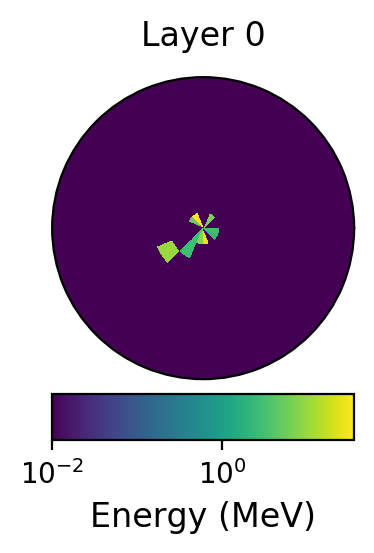

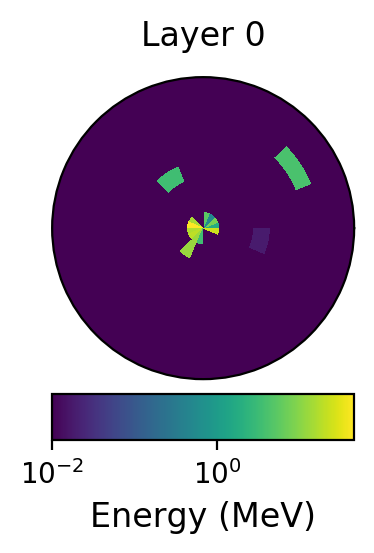

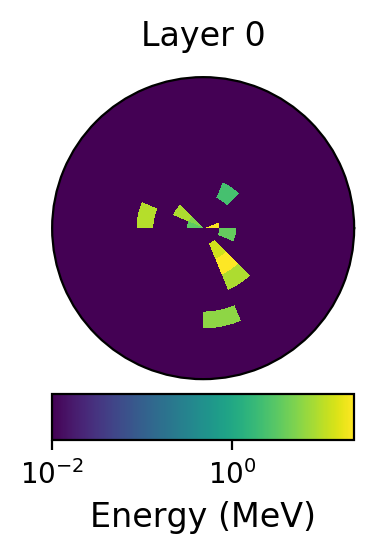

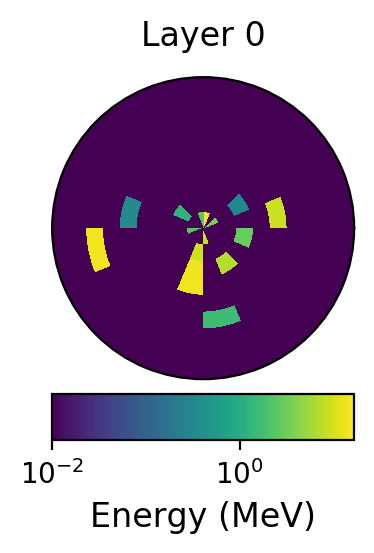

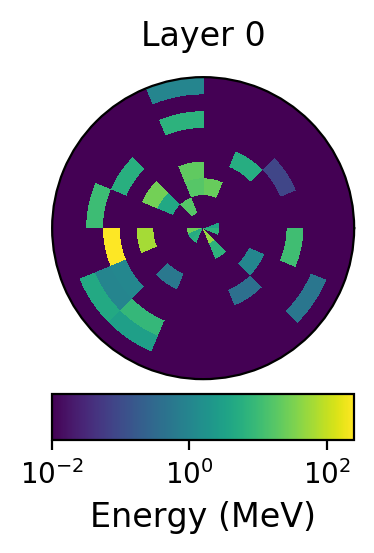

In [8]:
for i in range(10):
    DrawSingleLayer(Data_HLF, first_layer[i], 0)

In [8]:
ALPHA = 1e-6
def logit(x):
    """ returns logit of input """
    return np.log(x / (1.0 - x))

def sigmoid(x):
    """ returns sigmoid of input """
    return np.exp(x) / (np.exp(x) + 1.)

def logit_trafo(x):
    """ implements logit trafo of MAF paper https://arxiv.org/pdf/1705.07057.pdf """
    local_x = ALPHA + (1. - 2.*ALPHA) * x
    return logit(local_x)

def inverse_logit(x, clamp_low=0., clamp_high=1.):
    """ inverts logit_trafo(), clips result if needed """
    return ((sigmoid(x) - ALPHA) / (1. - 2.*ALPHA)).clip(clamp_low, clamp_high)

def separation_power(hist1, hist2, bins):
    """ computes the separation power aka triangular discrimination (cf eq. 15 of 2009.03796)
        Note: the definition requires Sum (hist_i) = 1, so if hist1 and hist2 come from
        plt.hist(..., density=True), we need to multiply hist_i by the bin widhts
    """
    hist1, hist2 = hist1*np.diff(bins), hist2*np.diff(bins)
    ret = (hist1 - hist2)**2
    ret /= hist1 + hist2 + 1e-16
    return 0.5 * ret.sum()


## first rough try

In [10]:
batch_size = 200
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

data_train = torch.split(torch.from_numpy(logit_trafo(first_layer/first_layer.max())).to(device), batch_size)
cond_train = torch.split(torch.from_numpy(np.log10(E_inc)).to(device), batch_size)

In [11]:
print("Working on {}".format(device))

flow_params_RQS = {'num_blocks': 1, # num of hidden layers per block
                   'use_residual_blocks': False,
                   'use_batch_norm': False,
                   'dropout_probability': 0.,
                   'activation': F.relu,
                   'random_mask':False,
                   'num_bins': 8,
                   'tails':'linear',
                   'tail_bound': 14.,
                   'min_bin_width': 1e-6,
                   'min_bin_height': 1e-6,
                   'min_derivative': 1e-6}
flow_blocks = []
for i in range(6):
    flow_blocks.append(transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                        **flow_params_RQS,
                        features=ds2_layer_size,
                        context_features=1,
                        hidden_features=128))
    if i%2 == 0:
        flow_blocks.append(transforms.ReversePermutation(ds2_layer_size))
    else:
        flow_blocks.append(transforms.RandomPermutation(ds2_layer_size))

del flow_blocks[-1]
flow_transform = transforms.CompositeTransform(flow_blocks)
flow_base_distribution = distributions.StandardNormal(shape=[ds2_layer_size])

flow = flows.Flow(transform=flow_transform, distribution=flow_base_distribution)

model = flow.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print(model)

total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Flow has {} parameters".format(total_parameters))

Working on cuda:1
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=144, out_features=128, bias=True)
          (context_layer): Linear(in_features=1, out_features=128, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=3312, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=144, out_features=128, bias=True)
          (context_layer): Linear(in_features=1, out_features=128, bias=True)
 

In [12]:
num_epochs = 15
for epoch in range(num_epochs):
    loglike = []
    for idx, batch in enumerate(data_train):
        if idx < 400:
            # train:
            model.train()
            loss = - model.log_prob(batch, cond_train[idx]).mean(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if idx % 100 == 0:
                print('epoch {:3d} / {}, step {:4d} / {}; loss {:.4f}'.format(
                    epoch+1, num_epochs, idx+1, len(data_train), loss.item()))
        else:
            # evaluate:
            model.eval()
            with torch.no_grad():
                loglike.append(model.log_prob(batch, cond_train[idx]))

    logprobs = torch.cat(loglike, dim=0)

    logprob_mean = logprobs.mean(0)
    logprob_std = logprobs.var(0).sqrt()

    output = 'Evaluate (epoch {}) -- '.format(epoch+1) +\
        'logp(x, at E(x)) = {:.3f} +/- {:.3f}'
    print(output.format(logprob_mean, logprob_std))



epoch   1 / 15, step    1 / 500; loss 12506.3129
epoch   1 / 15, step  101 / 500; loss 319.2728
epoch   1 / 15, step  201 / 500; loss -163.7027
epoch   1 / 15, step  301 / 500; loss -264.1868
Evaluate (epoch 1) -- logp(x, at E(x)) = 294.856 +/- 197.222
epoch   2 / 15, step    1 / 500; loss -309.0163
epoch   2 / 15, step  101 / 500; loss -329.5481
epoch   2 / 15, step  201 / 500; loss -341.3388
epoch   2 / 15, step  301 / 500; loss -387.7513
Evaluate (epoch 2) -- logp(x, at E(x)) = 384.404 +/- 206.635
epoch   3 / 15, step    1 / 500; loss -397.5354
epoch   3 / 15, step  101 / 500; loss -400.4325
epoch   3 / 15, step  201 / 500; loss -400.5957
epoch   3 / 15, step  301 / 500; loss -437.8048
Evaluate (epoch 3) -- logp(x, at E(x)) = 423.639 +/- 210.992
epoch   4 / 15, step    1 / 500; loss -436.5411
epoch   4 / 15, step  101 / 500; loss -434.4362
epoch   4 / 15, step  201 / 500; loss -434.2879
epoch   4 / 15, step  301 / 500; loss -464.6628
Evaluate (epoch 4) -- logp(x, at E(x)) = 451.106 

In [13]:
with torch.no_grad():
    model.eval()
    energies = torch.tensor([3., 4., 5., 6.]).reshape(-1, 1).to(device)
    samples = model.sample(5, energies)

samples = inverse_logit(samples.cpu().numpy())* first_layer.max()


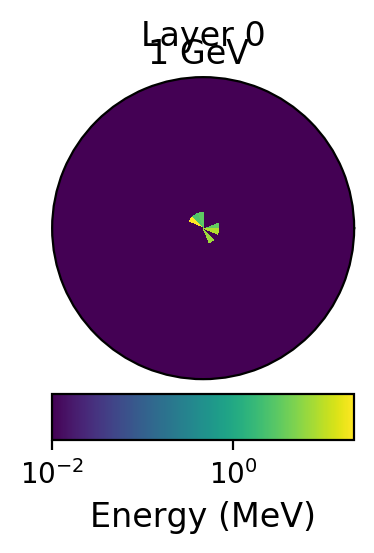

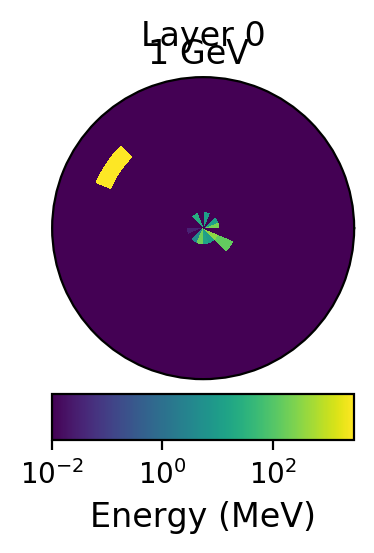

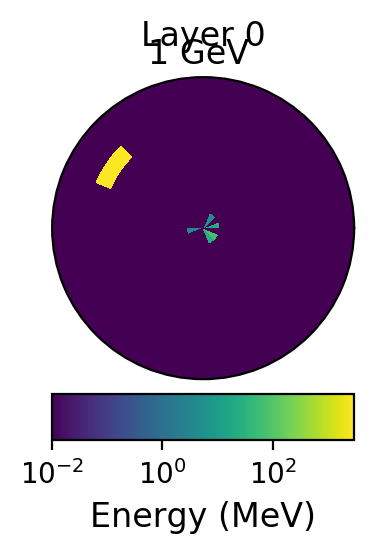

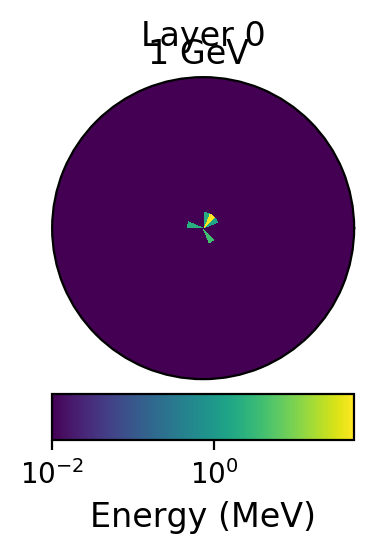

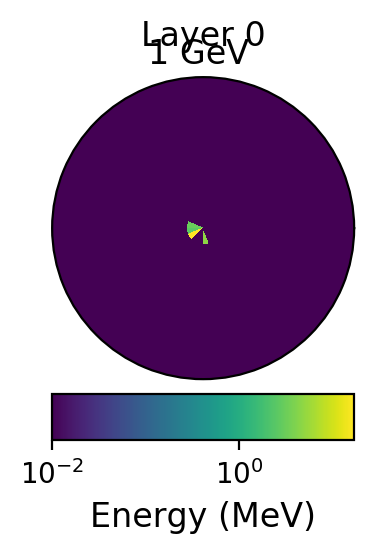

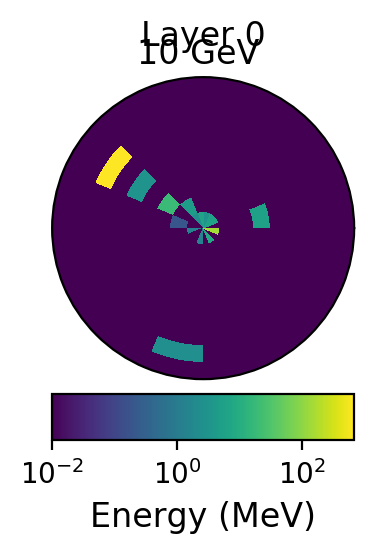

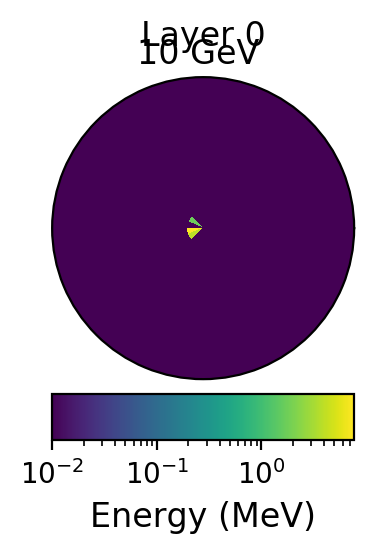

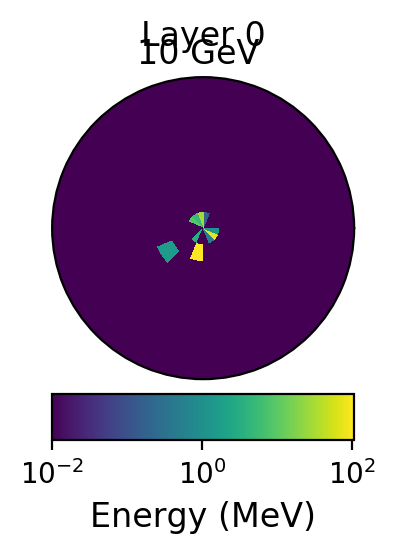

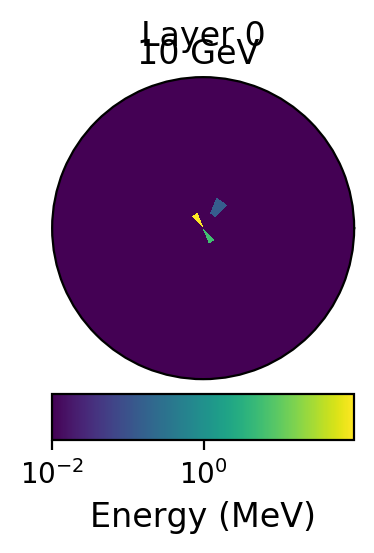

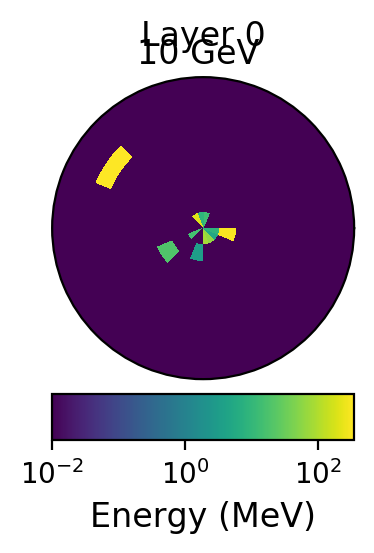

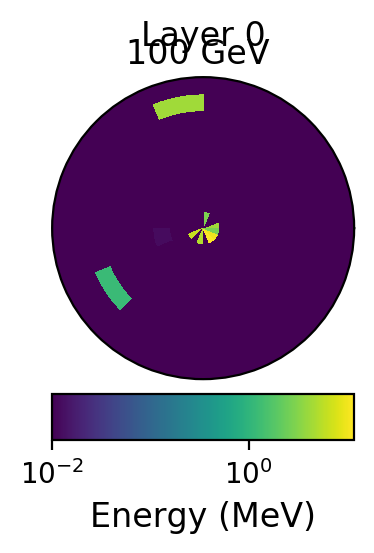

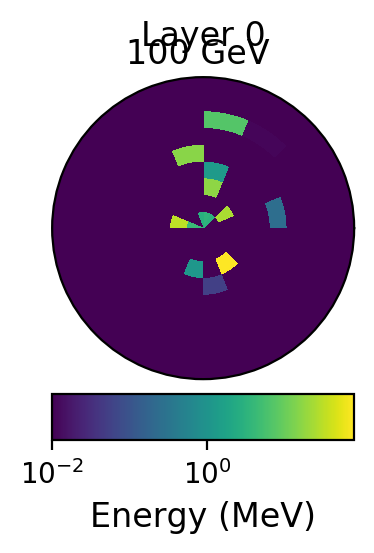

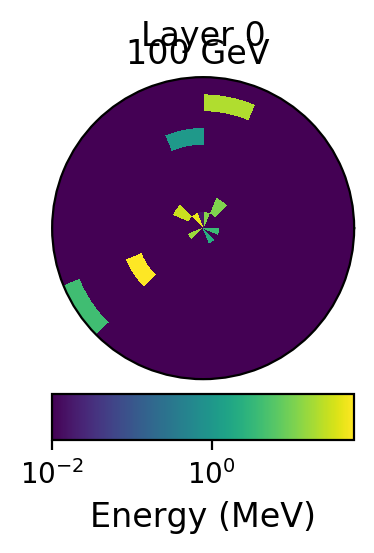

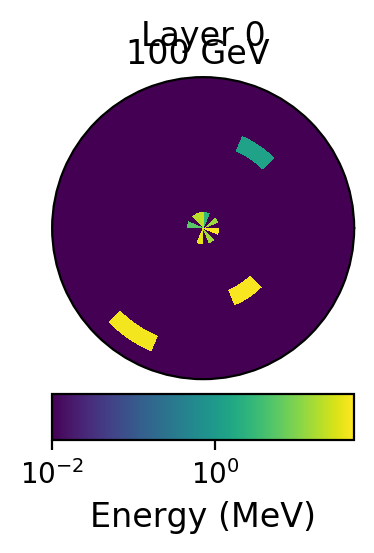

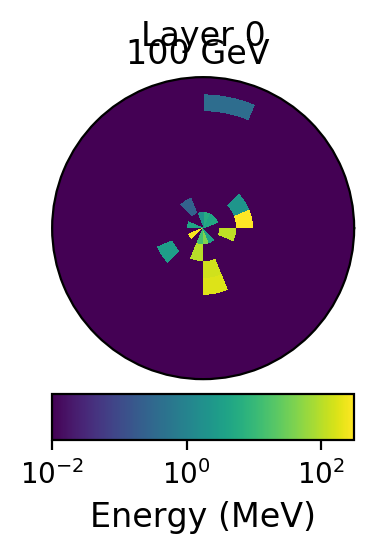

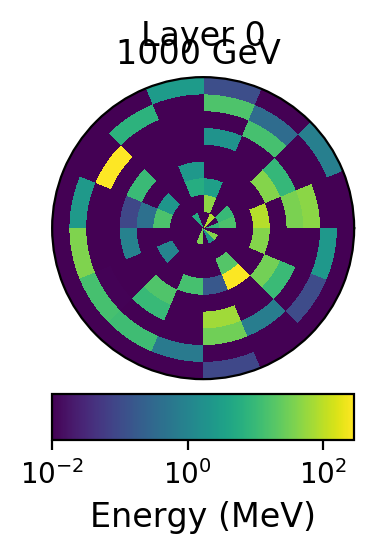

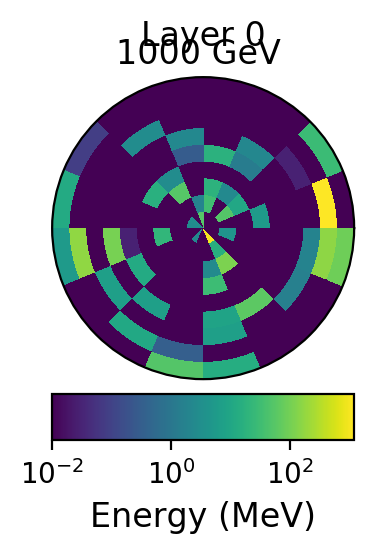

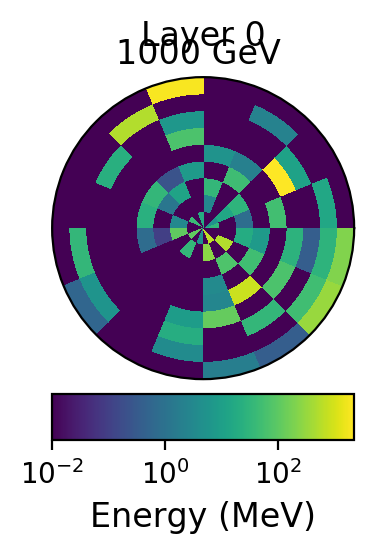

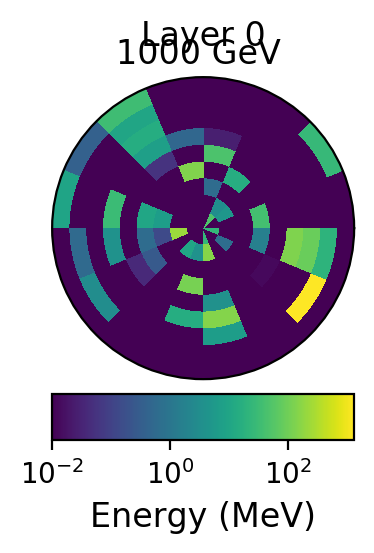

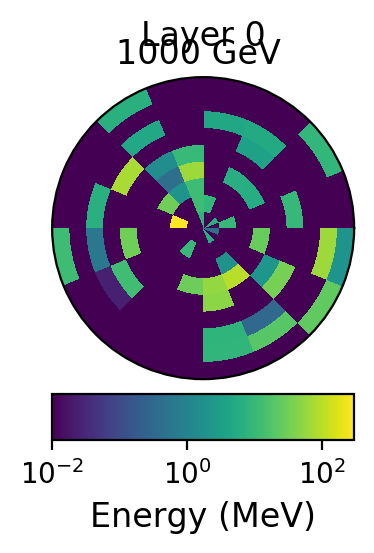

In [15]:
for energy, samples_en in enumerate(samples):
    for sample in samples_en:
        DrawSingleLayer(Data_HLF, sample, 0, title='{} GeV'.format(10**energy))

In [16]:
num_samples = 10000
with torch.no_grad():
    model.eval()
    cond_sample = (torch.rand(size=(num_samples, 1))*3. + 3.).to(device)
    samples = model.sample(1, cond_sample)
samples = inverse_logit(samples.cpu().numpy())* first_layer.max()


Separation power of histogram: 0.002599762537221865


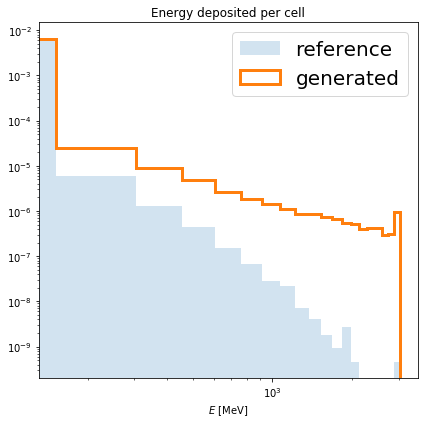

In [17]:
plt.figure(figsize=(6, 6))
counts_ref, bins, _ = plt.hist(first_layer.reshape(-1, 1), bins=20,
                                       label='reference', density=True, histtype='stepfilled',
                                       alpha=0.2, linewidth=2.)
counts_data, _, _ = plt.hist(samples.reshape(-1, 1), label='generated', bins=bins,
                                     histtype='step', linewidth=3., alpha=1., density=True)
plt.title("Energy deposited per cell")
plt.xlabel(r'$E$ [MeV]')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=20)
plt.tight_layout()
seps = separation_power(counts_ref, counts_data, bins)
print("Separation power of histogram: {}".format(seps))
plt.show()


Separation power of histogram: 0.1067528007547392


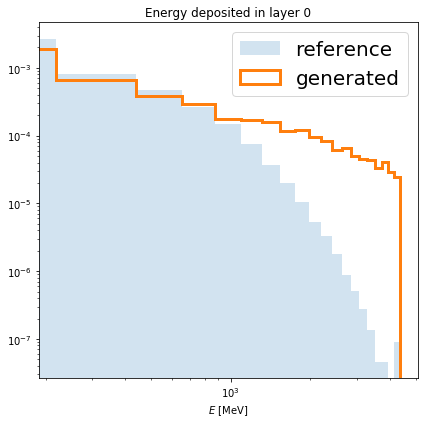

In [18]:
plt.figure(figsize=(6, 6))
counts_ref, bins, _ = plt.hist(first_layer.reshape(-1, ds2_layer_size).sum(axis=-1), bins=20,
                                       label='reference', density=True, histtype='stepfilled',
                                       alpha=0.2, linewidth=2.)
counts_data, _, _ = plt.hist(samples.reshape(-1, ds2_layer_size).sum(axis=-1), label='generated', bins=bins,
                                     histtype='step', linewidth=3., alpha=1., density=True)
plt.title("Energy deposited in layer 0")
plt.xlabel(r'$E$ [MeV]')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=20)
plt.tight_layout()
seps = separation_power(counts_ref, counts_data, bins)
print("Separation power of histogram: {}".format(seps))
plt.show()


## with decent dataloader

In [9]:
from torch.utils.data import Dataset, DataLoader

def add_noise(input_array, noise_level=1e-4):
    noise = np.random.rand(*input_array.shape)*noise_level
    return (input_array+noise)/(1.+noise_level)


class CaloLayerOne(Dataset):
    """ Dataloader for first Calorimeter Layer """
    def __init__(self, path_to_file, which_ds='2', with_noise=False, apply_logit=True, 
                 beginning_idx=0, data_length=100000):
        """
        Args:
            path_to_file (string): path to .hdf5 file
            which_ds ('2' or '3'): which dataset (kind of redundant with path_to_file name)
            with_noise (bool): whether or not to apply noise to bare voxel energies
            apply_logit (bool): whether or not logit transforming the energies before returning
            beginning_idx (int): at which index of original file to start taking data from
            data_length (int): how many events to contain
        """

        self.layer_size = {'2': 9 * 16, '3': 18 * 50}[which_ds]
        self.full_file = h5py.File(path_to_file, 'r')

        self.apply_logit = apply_logit
        self.with_noise = with_noise

        # in MeV:        
        self.E_inc = self.full_file['incident_energies'][beginning_idx:beginning_idx+data_length]
        self.layer_0 = self.full_file['showers'][:, :self.layer_size]
        self.layer_0 = self.layer_0[beginning_idx:beginning_idx+data_length]/self.layer_0.max()
        
        self.full_file.close()

    def __len__(self):
        # assuming file was written correctly
        return len(self.E_inc)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        layer_0 = self.layer_0[idx]
        energy = self.E_inc[idx]

        if self.with_noise:
            layer_0 = add_noise(layer_0)

        if self.apply_logit:
            layer_0 = logit_trafo(layer_0)

        sample = {'layer_0': layer_0, 'energy': energy}

        return sample

def get_dataloader(path_to_file, device, which_ds='2', batch_size=32, with_noise=False, apply_logit=True):

    kwargs = {'num_workers': 2, 'pin_memory': True} if device.type is 'cuda' else {}
    
    train_length = 70000
    test_length = 30000

    train_dataset = CaloLayerOne(path_to_file, which_ds=which_ds, with_noise=with_noise, apply_logit=apply_logit,
                                 beginning_idx=0, data_length=train_length)
    test_dataset = CaloLayerOne(path_to_file, which_ds=which_ds, with_noise=with_noise, apply_logit=apply_logit,
                                beginning_idx=train_length, data_length=test_length)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, **kwargs)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, **kwargs)
    return train_dataloader, test_dataloader

In [10]:
batch_size = 500
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_dataloader(ds2_folder+'dataset_2_1.hdf5', device, which_ds='2', batch_size=batch_size,
                                          with_noise=True, apply_logit=True)


In [11]:
print("Working on {}".format(device))

flow_params_RQS = {'num_blocks': 1, # num of hidden layers per block
                   'use_residual_blocks': False,
                   'use_batch_norm': False,
                   'dropout_probability': 0.,
                   'activation': F.relu,
                   'random_mask':False,
                   'num_bins': 8,
                   'tails':'linear',
                   'tail_bound': 14.,
                   'min_bin_width': 1e-6,
                   'min_bin_height': 1e-6,
                   'min_derivative': 1e-6}
flow_blocks = []
for i in range(6):
    flow_blocks.append(transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                        **flow_params_RQS,
                        features=ds2_layer_size,
                        context_features=1,
                        hidden_features=128))
    if i%2 == 0:
        flow_blocks.append(transforms.ReversePermutation(ds2_layer_size))
    else:
        flow_blocks.append(transforms.RandomPermutation(ds2_layer_size))

del flow_blocks[-1]
flow_transform = transforms.CompositeTransform(flow_blocks)
flow_base_distribution = distributions.StandardNormal(shape=[ds2_layer_size])

flow = flows.Flow(transform=flow_transform, distribution=flow_base_distribution)

model = flow.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print(model)

total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Flow has {} parameters".format(total_parameters))

Working on cuda:1
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=144, out_features=128, bias=True)
          (context_layer): Linear(in_features=1, out_features=128, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=3312, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=144, out_features=128, bias=True)
          (context_layer): Linear(in_features=1, out_features=128, bias=True)
 

In [12]:
num_epochs = 100
for epoch in range(num_epochs):
    loglike = []
    # train:
    for idx, batch in enumerate(train_loader):
        model.train()
        shower = batch['layer_0'].to(device)
        cond = torch.log10(batch['energy']).to(device) -4.5
        loss = - model.log_prob(shower, cond).mean(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 20 == 0:
            print('epoch {:3d} / {}, step {:4d} / {}; loss {:.4f}'.format(
                    epoch+1, num_epochs, idx+1, len(train_loader), loss.item()))
    # evaluate:
    for idx, batch in enumerate(test_loader):
        model.eval()
        shower = batch['layer_0'].to(device)
        cond = torch.log10(batch['energy']).to(device) -4.5

        with torch.no_grad():
            loglike.append(model.log_prob(shower, cond))

    logprobs = torch.cat(loglike, dim=0)

    logprob_mean = logprobs.mean(0)
    logprob_std = logprobs.var(0).sqrt()

    output = 'Evaluate (epoch {}) -- '.format(epoch+1) +\
        'logp(x, at E(x)) = {:.3f} +/- {:.3f}'
    print(output.format(logprob_mean, logprob_std))



epoch   1 / 100, step    1 / 140; loss 6410.2554
epoch   1 / 100, step   21 / 140; loss 2387.3608
epoch   1 / 100, step   41 / 140; loss 851.7950
epoch   1 / 100, step   61 / 140; loss 475.8278
epoch   1 / 100, step   81 / 140; loss 380.0591
epoch   1 / 100, step  101 / 140; loss 349.9586
epoch   1 / 100, step  121 / 140; loss 324.2180
Evaluate (epoch 1) -- logp(x, at E(x)) = -302.597 +/- 63.051
epoch   2 / 100, step    1 / 140; loss 304.2180
epoch   2 / 100, step   21 / 140; loss 287.4379
epoch   2 / 100, step   41 / 140; loss 274.2812
epoch   2 / 100, step   61 / 140; loss 262.7146
epoch   2 / 100, step   81 / 140; loss 254.5210
epoch   2 / 100, step  101 / 140; loss 254.7578
epoch   2 / 100, step  121 / 140; loss 244.8880
Evaluate (epoch 2) -- logp(x, at E(x)) = -241.090 +/- 48.644
epoch   3 / 100, step    1 / 140; loss 242.4985
epoch   3 / 100, step   21 / 140; loss 239.5225
epoch   3 / 100, step   41 / 140; loss 235.4266
epoch   3 / 100, step   61 / 140; loss 233.1085
epoch   3 / 

epoch  21 / 100, step  101 / 140; loss 202.1353
epoch  21 / 100, step  121 / 140; loss 201.2423
Evaluate (epoch 21) -- logp(x, at E(x)) = -201.150 +/- 44.947
epoch  22 / 100, step    1 / 140; loss 197.7136
epoch  22 / 100, step   21 / 140; loss 200.4433
epoch  22 / 100, step   41 / 140; loss 199.7908
epoch  22 / 100, step   61 / 140; loss 203.6981
epoch  22 / 100, step   81 / 140; loss 199.6221
epoch  22 / 100, step  101 / 140; loss 200.7579
epoch  22 / 100, step  121 / 140; loss 198.7960
Evaluate (epoch 22) -- logp(x, at E(x)) = -200.921 +/- 44.887
epoch  23 / 100, step    1 / 140; loss 200.5308
epoch  23 / 100, step   21 / 140; loss 202.1234
epoch  23 / 100, step   41 / 140; loss 200.6492
epoch  23 / 100, step   61 / 140; loss 201.1790
epoch  23 / 100, step   81 / 140; loss 203.4574
epoch  23 / 100, step  101 / 140; loss 197.5509
epoch  23 / 100, step  121 / 140; loss 200.1524
Evaluate (epoch 23) -- logp(x, at E(x)) = -200.597 +/- 44.936
epoch  24 / 100, step    1 / 140; loss 202.103

epoch  42 / 100, step   41 / 140; loss 191.9283
epoch  42 / 100, step   61 / 140; loss 195.6003
epoch  42 / 100, step   81 / 140; loss 196.8450
epoch  42 / 100, step  101 / 140; loss 200.4980
epoch  42 / 100, step  121 / 140; loss 198.3612
Evaluate (epoch 42) -- logp(x, at E(x)) = -197.339 +/- 44.505
epoch  43 / 100, step    1 / 140; loss 200.5200
epoch  43 / 100, step   21 / 140; loss 198.7090
epoch  43 / 100, step   41 / 140; loss 194.3844
epoch  43 / 100, step   61 / 140; loss 195.1765
epoch  43 / 100, step   81 / 140; loss 194.4191
epoch  43 / 100, step  101 / 140; loss 193.3660
epoch  43 / 100, step  121 / 140; loss 199.1919
Evaluate (epoch 43) -- logp(x, at E(x)) = -197.465 +/- 44.386
epoch  44 / 100, step    1 / 140; loss 198.2723
epoch  44 / 100, step   21 / 140; loss 200.0899
epoch  44 / 100, step   41 / 140; loss 196.4781
epoch  44 / 100, step   61 / 140; loss 195.4653
epoch  44 / 100, step   81 / 140; loss 199.2985
epoch  44 / 100, step  101 / 140; loss 199.7294
epoch  44 / 

Evaluate (epoch 62) -- logp(x, at E(x)) = -195.845 +/- 44.336
epoch  63 / 100, step    1 / 140; loss 193.5385
epoch  63 / 100, step   21 / 140; loss 193.2106
epoch  63 / 100, step   41 / 140; loss 196.3203
epoch  63 / 100, step   61 / 140; loss 197.7647
epoch  63 / 100, step   81 / 140; loss 190.5629
epoch  63 / 100, step  101 / 140; loss 196.6143
epoch  63 / 100, step  121 / 140; loss 195.4134
Evaluate (epoch 63) -- logp(x, at E(x)) = -195.799 +/- 44.377
epoch  64 / 100, step    1 / 140; loss 197.1196
epoch  64 / 100, step   21 / 140; loss 195.3666
epoch  64 / 100, step   41 / 140; loss 198.8536
epoch  64 / 100, step   61 / 140; loss 193.6521
epoch  64 / 100, step   81 / 140; loss 195.2243
epoch  64 / 100, step  101 / 140; loss 195.0965
epoch  64 / 100, step  121 / 140; loss 194.0615
Evaluate (epoch 64) -- logp(x, at E(x)) = -195.521 +/- 44.345
epoch  65 / 100, step    1 / 140; loss 192.9826
epoch  65 / 100, step   21 / 140; loss 197.5491
epoch  65 / 100, step   41 / 140; loss 198.209

epoch  83 / 100, step   81 / 140; loss 193.6291
epoch  83 / 100, step  101 / 140; loss 196.1143
epoch  83 / 100, step  121 / 140; loss 192.7374
Evaluate (epoch 83) -- logp(x, at E(x)) = -194.921 +/- 44.349
epoch  84 / 100, step    1 / 140; loss 194.9912
epoch  84 / 100, step   21 / 140; loss 195.5247
epoch  84 / 100, step   41 / 140; loss 192.7808
epoch  84 / 100, step   61 / 140; loss 195.5279
epoch  84 / 100, step   81 / 140; loss 200.5169
epoch  84 / 100, step  101 / 140; loss 193.9191
epoch  84 / 100, step  121 / 140; loss 196.4511
Evaluate (epoch 84) -- logp(x, at E(x)) = -195.127 +/- 44.107
epoch  85 / 100, step    1 / 140; loss 196.6855
epoch  85 / 100, step   21 / 140; loss 196.2670
epoch  85 / 100, step   41 / 140; loss 193.2772
epoch  85 / 100, step   61 / 140; loss 195.3726
epoch  85 / 100, step   81 / 140; loss 196.0052
epoch  85 / 100, step  101 / 140; loss 198.2641
epoch  85 / 100, step  121 / 140; loss 193.1297
Evaluate (epoch 85) -- logp(x, at E(x)) = -195.165 +/- 44.11

In [13]:
with torch.no_grad():
    model.eval()
    energies = torch.tensor([3., 4., 5., 6.]).reshape(-1, 1).to(device) - 4.5
    samples = model.sample(5, energies)

samples = inverse_logit(samples.cpu().numpy())* first_layer.max()


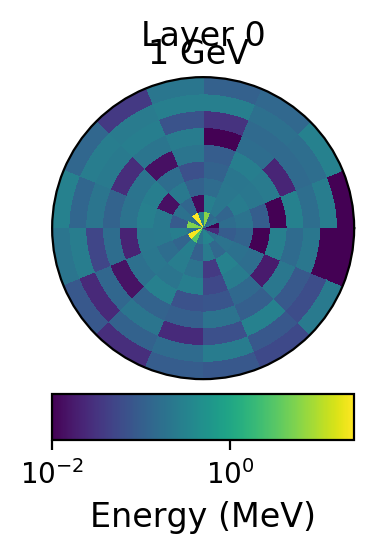

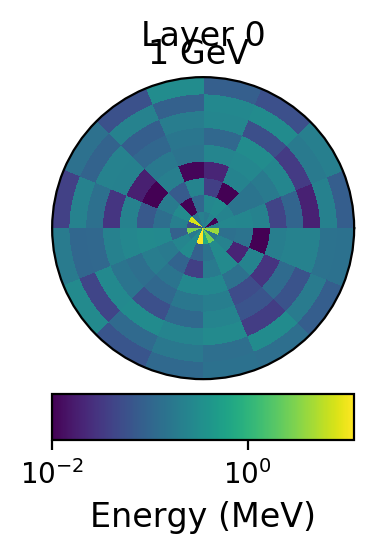

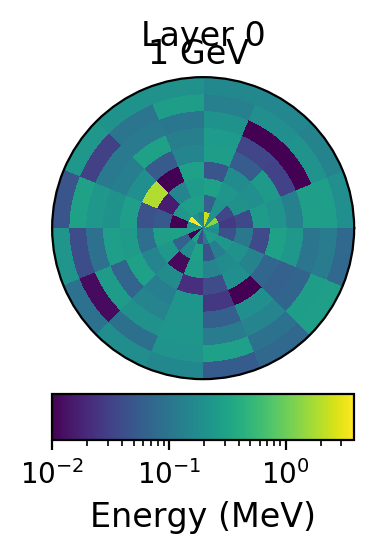

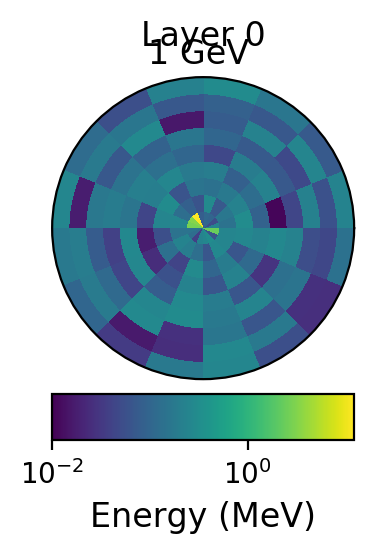

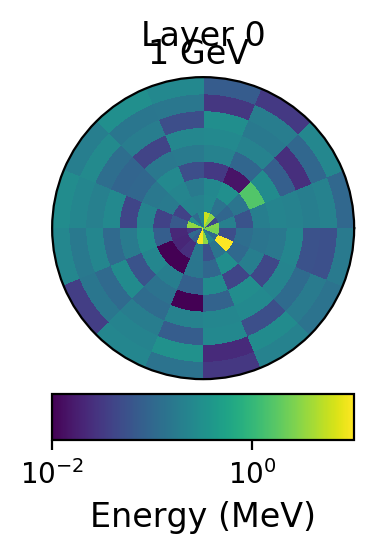

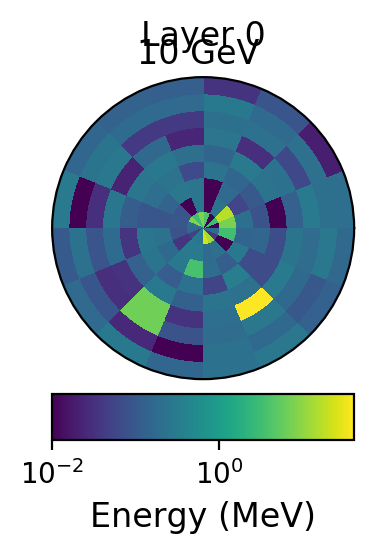

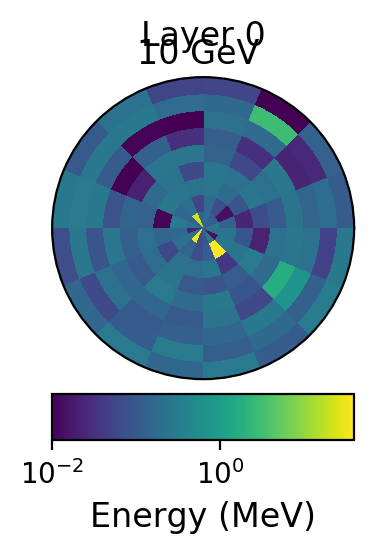

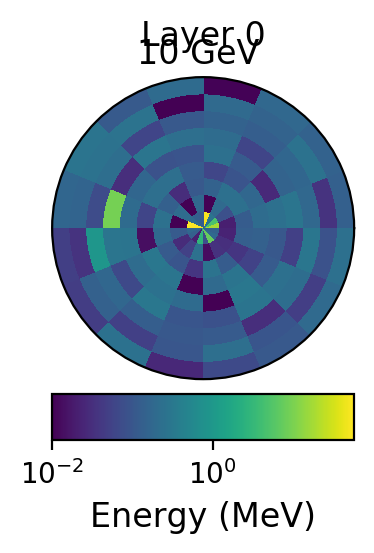

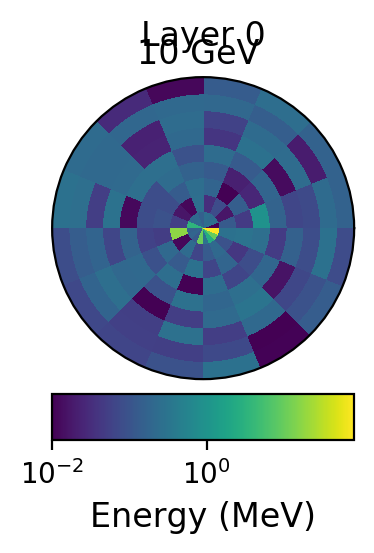

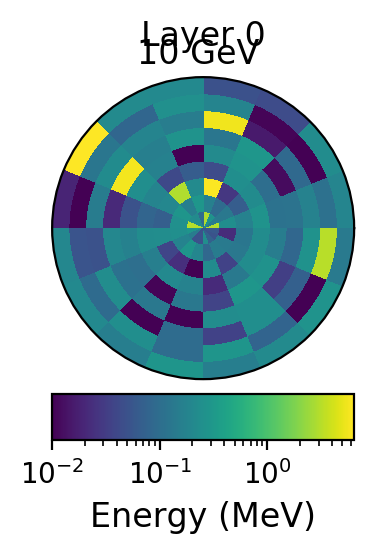

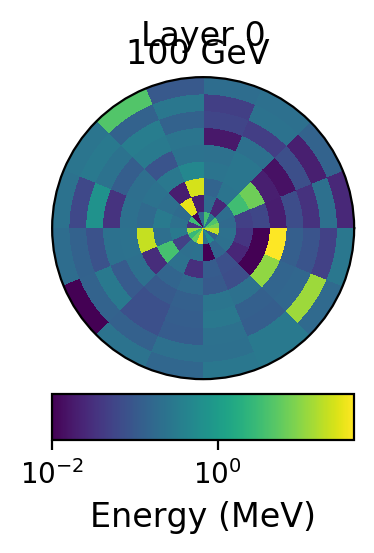

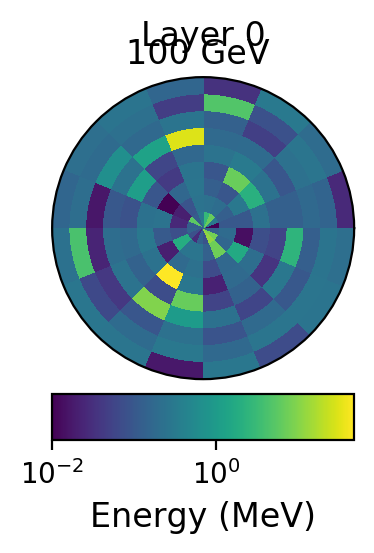

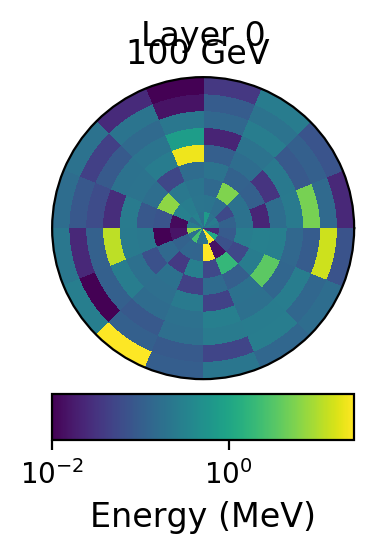

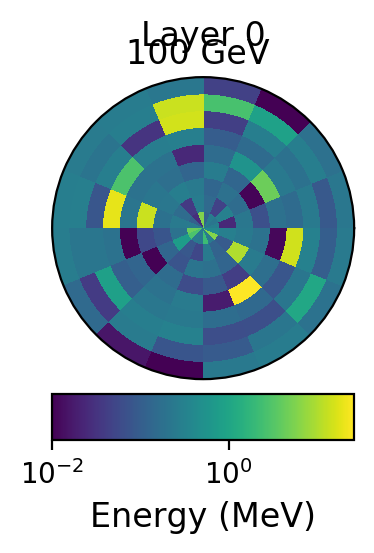

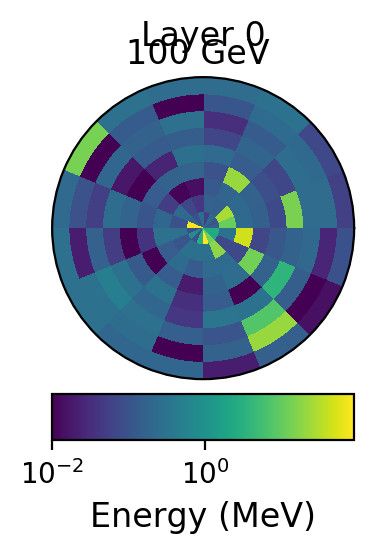

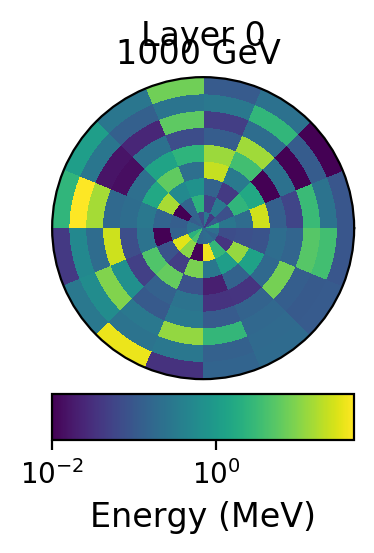

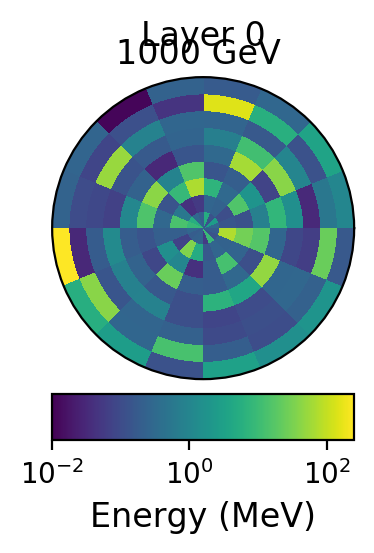

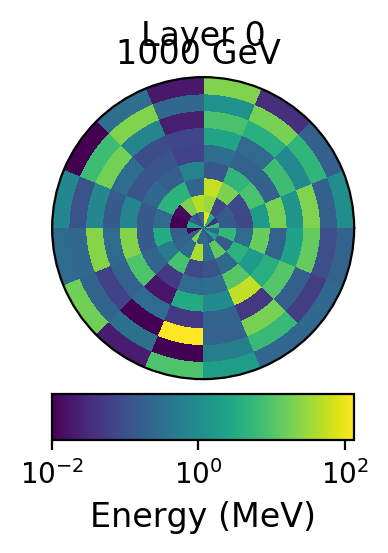

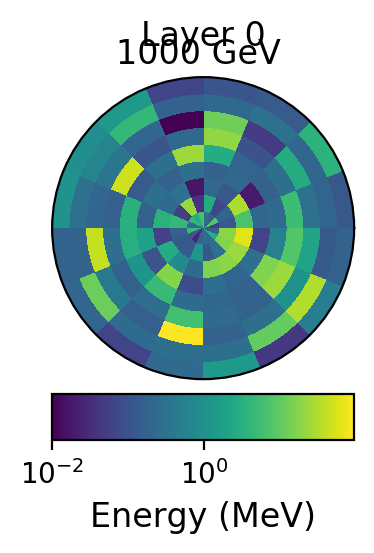

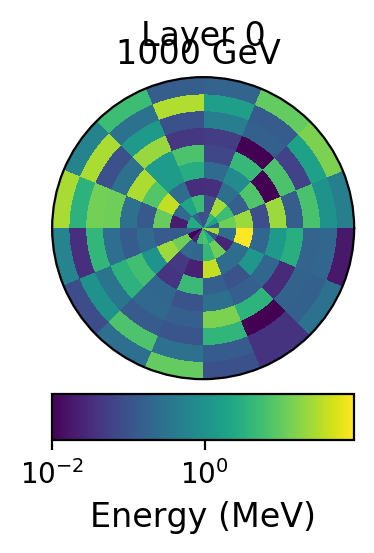

In [14]:
for energy, samples_en in enumerate(samples):
    for sample in samples_en:
        DrawSingleLayer(Data_HLF, sample, 0, title='{} GeV'.format(10**(energy)))

In [21]:
# I had memory issues generating 50k at once, so I do it in 10 batches (it's slow, I know...)
full_samples = []
num_samples = 5000
with torch.no_grad():
    model.eval()
    for i in range(10):
        cond_sample = (torch.rand(size=(num_samples, 1))*3. + 3.).to(device) - 4.5
        samples = model.sample(1, cond_sample)
        full_samples.append(inverse_logit(samples.cpu().numpy())* first_layer.max())
        print("Done with {}/10".format(i+1), end='\r')
        
samples = np.array(full_samples)


Separation power of histogram: 1.4409834155646128e-05


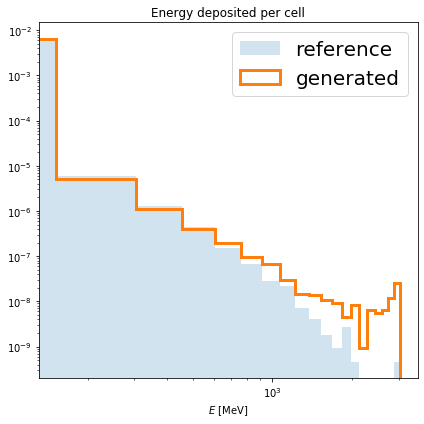

In [22]:
plt.figure(figsize=(6, 6))
counts_ref, bins, _ = plt.hist(first_layer.reshape(-1, 1), bins=20,
                                       label='reference', density=True, histtype='stepfilled',
                                       alpha=0.2, linewidth=2.)
counts_data, _, _ = plt.hist(samples.reshape(-1, 1), label='generated', bins=bins,
                                     histtype='step', linewidth=3., alpha=1., density=True)
plt.title("Energy deposited per cell")
plt.xlabel(r'$E$ [MeV]')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=20)
plt.tight_layout()
seps = separation_power(counts_ref, counts_data, bins)
print("Separation power of histogram: {}".format(seps))
plt.show()


Separation power of histogram: 0.0013077950743547316


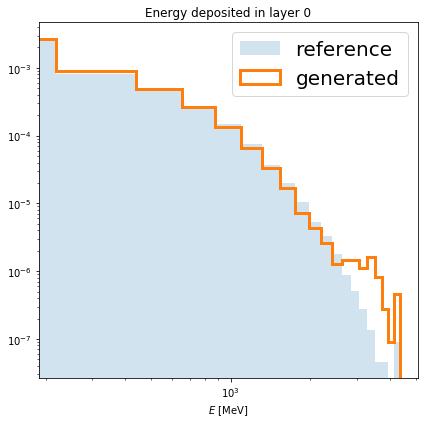

In [23]:
plt.figure(figsize=(6, 6))
counts_ref, bins, _ = plt.hist(first_layer.reshape(-1, ds2_layer_size).sum(axis=-1), bins=20,
                                       label='reference', density=True, histtype='stepfilled',
                                       alpha=0.2, linewidth=2.)
counts_data, _, _ = plt.hist(samples.reshape(-1, ds2_layer_size).sum(axis=-1), label='generated', bins=bins,
                                     histtype='step', linewidth=3., alpha=1., density=True)
plt.title("Energy deposited in layer 0")
plt.xlabel(r'$E$ [MeV]')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=20)
plt.tight_layout()
seps = separation_power(counts_ref, counts_data, bins)
print("Separation power of histogram: {}".format(seps))
plt.show()
